## Forest carbon fuelmap analysis

To run the analysis make sure the following files are available in a directory calld input

To run the analysis then hit shift-enter to execute the cells one by one.

#### Code

In [12]:
import terracatalogueclient
from terracatalogueclient import Catalogue
from shapely.geometry import Polygon
import logging
import sys
import os
import json
import natcap.invest.carbon
import natcap.invest.utils
from osgeo import gdal
from os.path import exists


def get_bounds(src_file):
    src = gdal.Open(src_file)
    ulx, xres, xskew, uly, yskew, yres  = src.GetGeoTransform()
    lrx = ulx + (src.RasterXSize * xres)
    lry = uly + (src.RasterYSize * yres)
    return (ulx, uly, lrx, lry)

# Download ground classification from AWS or (fallback to Terrascope) and crop to BarkBeetle map

import boto3
from botocore import UNSIGNED
from botocore.config import Config
from os.path import exists


def dowload_esa_worldcover(secrets_file_path, bounds, target_dir):
    # Lookup the correct mapID before downloading from S3

    # Load secret settings from file
    with open(secrets_file_path) as file:
            secret_data = json.load(file)

    # Using non-interactive authentication as interactive does not work. 
    catalogue = Catalogue().authenticate_non_interactive(secret_data['userid'], secret_data['password'])

    # Lookup the map part that countains the sought bounds
    geometry = Polygon.from_bounds(*bounds)
    product_count = catalogue.get_product_count("urn:eop:VITO:ESA_WorldCover_10m_2020_V1", geometry=geometry)
    if product_count == 0:
        print('No products found for the given boundary.')
    products = catalogue.get_products("urn:eop:VITO:ESA_WorldCover_10m_2020_V1", geometry=geometry)

    # Currently only handles one product at a time
    product = next(products)
    product_filepath = f'{target_dir}/{product.title}/{product.title}_Map.tif'
    
    if exists(product_filepath):
        print('Download already cached locally. Skipping download.')
    else:
        os.makedirs(f'{target_dir}/{product.title}')
        print(f'Downloading product: {product}')
        s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
        s3.download_file(Bucket='esa-worldcover', Key=f'v100/2020/map/{product.title}_Map.tif', Filename=product_filepath)

        # Could be used in case of error from AWS
        # catalogue.download_product(product, f'{target_dir}')
        
    return product.title, product_filepath
    

import numpy as np
import os
from matplotlib import pyplot

def tiffcrop( tif_to_crop_path, tif_cutter_path, output_file):
    src = gdal.Open(tif_cutter_path)
    ulx, xres, xskew, uly, yskew, yres  = src.GetGeoTransform()
    lrx = ulx + (src.RasterXSize * xres)
    lry = uly + (src.RasterYSize * yres)
    os.system(f'gdalwarp -te {ulx} {lry} {lrx} {uly} {tif_to_crop_path} {output_file} -overwrite -q')
    
def read_geotiff(filename):
    ds = gdal.Open(filename)
    band = ds.GetRasterBand(1)
    arr = band.ReadAsArray()
    return arr, ds

def write_geotiff(filename, arr, in_ds):
    if arr.dtype == np.float32:
        arr_type = gdal.GDT_Float32
    else:
        arr_type = gdal.GDT_Int32

    arr_type = gdal.GDT_Float32

    driver = gdal.GetDriverByName("GTiff")
    out_ds = driver.Create(filename, arr.shape[1], arr.shape[0], 1, arr_type)
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())
    band = out_ds.GetRasterBand(1)
    band.WriteArray(arr)
    band.FlushCache()
    band.ComputeStatistics(False)


def run_InVEST_analysis():
    # Originaly Generated by InVEST 3.11.0
    # Model: Carbon Storage and Sequestration

    LOGGER = logging.getLogger(__name__)
    root_logger = logging.getLogger()

    handler = logging.StreamHandler(sys.stdout)
    formatter = logging.Formatter(
        fmt=natcap.invest.utils.LOG_FMT,
        datefmt='%m/%d/%Y %H:%M:%S ')
    handler.setFormatter(formatter)
    logging.basicConfig(level=logging.INFO, handlers=[handler])

    args = {
        'calc_sequestration': True,
        'carbon_pools_path': carbon_pools_path,
        'discount_rate': '',
        'do_redd': False,
        'do_valuation': False,
        'lulc_cur_path': ground_classification_cropped_path,
        'lulc_cur_year': '',
        'lulc_fut_path': '',
        'lulc_fut_year': '',
        'lulc_redd_path': '',
        'n_workers': '-1',
        'price_per_metric_ton_of_c': '',
        'rate_change': '',
        'results_suffix': '',
        'workspace_dir': InVEST_ws_dir,
    }

    natcap.invest.carbon.execute(args)

def compute_fuelmap():
    dt_b1, dt = read_geotiff(dt_analysis_path)
    iv_b1, iv = read_geotiff(workspace_dir + '/tot_c_cur.tif')

    #dt = gdal.Open('input/PredCanada_11VPE_0-1.tif')
    #iv = gdal.Open('temp/tot_c_cur.tif')

    #dt_b1 = np.array(dt.GetRasterBand(1).ReadAsArray())
    #iv_b1 = np.array(iv.GetRasterBand(1).ReadAsArray())

    # Crop the invest file using DT as it may have warped a little after reprojection
    iv_b1 = iv_b1[0:dt_b1.shape[1], 0:dt_b1.shape[0]]

    # Remove all values less than 0 as they are no data and appear to be an artifact of InVest processing (the first row)
    #iv_b1 = np.where(iv_b1 > 0, iv_b1, 0)

    # Calculate fuelmap using dt as a filter and using a threshold of at least 0.3
    fuelmap_b1=np.multiply(dt_b1, iv_b1, where=dt_b1>0.3)

    write_geotiff(fuelmap_outfile, fuelmap_b1, dt)
    
def check_file_exists( filepath, error_message ):
    if not exists(filepath):
        raise Exception(error_message)

def showmap( filepath ):
    arr, ds = read_geotiff(filepath)
    pyplot.imshow(arr)
    
def compute_fuelmaps(invest_image, gc_image, bb_image, thres:float, res:int):
    
#    bb_result_path = workspace_dir+'/bb_result_'+str(res)+'.tif'
#    bb_output_path = workspace_dir+'/bb_output_'+str(res)+'.tif'
#    carbon_output_path = workspace_dir+'/carbon_output_'+str(res)+'.tif'
#    prio_path = workspace_dir+'/prio_'+str(res)+'.tif'

    output_path=workspace_dir+'/data/fuel/'+str(res)
    os.makedirs(output_path, exist_ok = True)

    tot_c_cur_data, _ = read_geotiff(invest_image)
    Gc_cropped_data, gc_meta = read_geotiff(gc_image)
    PredCanada_data, _ = read_geotiff(bb_image)

    # Appears this no more is needed?
    #adjusting image size
    #Gc_cropped_data=Gc_cropped_data[:-1]
    #tot_c_cur_data=tot_c_cur_data[:-1]

    # This one also may be of no use after switching to GDAL
    # Crop the invest file using DT as it may have warped a little after reprojection
    #PredCanada_data = PredCanada_data[0:Gc_cropped_data.shape[0], 0:Gc_cropped_data.shape[1]]

    #making forest map: forest:1, other:0
    Gc_cropped_data[Gc_cropped_data==10] = 1
    Gc_cropped_data[Gc_cropped_data!=1] = 0
    Gc_forest_map = Gc_cropped_data

    #bb prediction in only gc forest
    bb_result = Gc_forest_map*PredCanada_data

    #let bb prediciton values over threshold remain 
    bb_result_efter_thres = np.where(bb_result > thres, 1.0, 0.0)
    write_geotiff(workspace_dir+'/bb_result_'+str(res)+'.tif', bb_result_efter_thres, gc_meta )

    #downsampling
    gdal.Warp(workspace_dir+'/bb_output_'+str(res)+'.tif', workspace_dir+'/bb_result_'+str(res)+'.tif', xRes=res, yRes=res, resampleAlg='average', srcNodata=None )
    gdal.Warp(workspace_dir+'/carbon_output_'+str(res)+'.tif', invest_image, xRes=res, yRes=res, resampleAlg='sum')

    # Create prio list
    bb_out, bb_meta = read_geotiff(workspace_dir+'/bb_output_'+str(res)+'.tif')
    c_out, _ = read_geotiff(workspace_dir+'/carbon_output_'+str(res)+'.tif')

    #making prio list
    prio= np.sqrt(bb_out*c_out)

    write_geotiff(workspace_dir+'/prio_'+str(res)+'.tif', prio, bb_meta )
    return c_out, bb_out, prio

import pandas as pd
def show_carbon_priority_table(carbon_out, bb_out, prio_out, res:int):

    if res==2000:
        bb_out=bb_out*1000
    
    bbout=np.reshape(bb_out, newshape=-1)
    cout=np.reshape(carbon_out, newshape=-1)
    pout=np.reshape(prio_out, newshape=-1)

    if res==2000:
        num=14
    elif res==500:
        num=56

    X=[]
    Y=[]
    for i in range(num):
        for j in range(num):
            X.append(str(j))
            Y.append(str(i))

    data ={ 'X': X,
            'Y': Y,
            'Dead_tree(‰)': bbout,
            'Carbon(Mg C)':cout,
            'Prio':pout}

    Cols=[('X'),('Y'),('Dead_tree(‰)'),('Carbon(Mg C)'),('Prio')]
    df = pd.DataFrame(data,columns=Cols)
    df_sort = df.sort_values(by=['Prio'], ascending=False)
    print(df_sort.head(15))


def scale_hsv(mx):
    mx[:,:,1] /= mx[:,:,1].max()
    mx[:,:,2] /= mx[:,:,2].max()
    return mx

from matplotlib.colors import hsv_to_rgb
import matplotlib.pyplot as plt


def hsv_imshow(hsv_map, hires_ticks=False):
    hsv_map = hsv_to_rgb(hsv_map)
    plt.imshow(hsv_map)
    x=hsv_map.shape[0]
    if hires_ticks:
        plt.xticks(range(0, x+1, 1))
        plt.yticks(range(0, x+1, 1))
#    plt.xlabel(f'1:{28000/x:.0} [m]')
#    plt.ylabel(f'1:{28000/x:.0} [m]')
    import matplotlib.patches as mpatches
    pat = [mpatches.Patch(color='k', label="Dark-No CO"), 
           mpatches.Patch(color='r', label="Rec-Dead Wood"),
           mpatches.Patch(color='w', label="White-Healthy Wood")]
    plt.legend(handles=pat, loc=2, bbox_to_anchor=(1.05,1), borderaxespad=0.)
    plt.show()

def stack_hsv(bb, carbon):
    hsv_map = np.dstack((np.zeros_like(bb), bb, carbon))
    return scale_hsv(hsv_map)    
    
    
# Configure settings

# Create necessary directories
workspace_dir = 'temp'
input_dir ='input'
output_dir = 'output'
os.makedirs(workspace_dir, exist_ok=True)
os.makedirs(input_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

# Starting point of the DT analysis file
# Todo: Make this selectable
dt_analysis_path = input_dir+'/PredCanada_11VPE_0-1.tif'

# For logging in to get map catalogue
# Has the format
# {
#     "userid": "USERNAME",
#     "password": "PASSWORD"
# }
secrets_file_path = input_dir+"/secret.json"

# A temporary file for getting the AOI
dt_analysis_crs_temp_path = workspace_dir+'/dt_analysis_crs_temp.tif'

# The cropped GC file ready processed for InVEST
ground_classification_cropped_path = workspace_dir+'/gc_cropped.tif'

# InVEST workspace dir
InVEST_ws_dir = workspace_dir
carbon_pools_path = input_dir+'/carbon_pools_canada.csv'

# Fuelmap
fuelmap_outfile=workspace_dir+'/fuelmap.tif'

# Fuelmaps
resample_resolution = 2000
significance_threshold = 0.5
bb_result_path = workspace_dir+'/bb_result_'+str(resample_resolution)+'.tif'
bb_output_path = workspace_dir+'/bb_output_'+str(resample_resolution)+'.tif'
carbon_output_path = workspace_dir+'/carbon_output_'+str(resample_resolution)+'.tif'
prio_path = workspace_dir+'/prio_'+str(resample_resolution)+'.tif'


# Make sure required prerequisite files exist        
check_file_exists(carbon_pools_path, f'The required file {carbon_pools_path} is missing. See documentation for details.')
check_file_exists(secrets_file_path, f'The required file {secrets_file_path} is missing. See documentation for details.')



#### Add dead tree analysis path

#### Create the fuelmap

In [13]:
print('Starting creation of fuelmap')

# Reproject image from from SRS 32611 to 4326 so we can extract the coordinates so as to look up the Terra tile.
os.system(f'gdalwarp -t_srs EPSG:4326 -r near -of GTiff {dt_analysis_path} {dt_analysis_crs_temp_path} -overwrite -q')

# Get the bounds using the reprojected raster, extract coordinates for map lookup in catalogue
bounds = get_bounds(dt_analysis_crs_temp_path)


print('Downloading and preparing ground classification. This will take a few seconds.')
# Download ground classification from AWS or (fallback to Terrascope) and crop to BarkBeetle map
product_title, product_path = dowload_esa_worldcover(secrets_file_path, bounds, workspace_dir)

print('Processing ground classification. This will take a few seconds')
# Reproject the ground classification to a projection that InVEST accepts
reprojected_product_path = f'{workspace_dir}/{product_title}/{product_title}_Map_reprojected.tif'
os.system(f'gdalwarp -t_srs EPSG:32611 -tr 10.0 10.0  -r near -of GTiff {product_path} {reprojected_product_path} -overwrite -q')

# Crop the ground classification to the DT analysis so they are the same size
tiffcrop(   reprojected_product_path,
            dt_analysis_path,
            ground_classification_cropped_path)

# Run the InVEST analysis software package
print('Running the InVEST carbon analysis')
run_InVEST_analysis()


print('Computing fuelmaps')
#compute_fuelmap()
_, _, _ = compute_fuelmaps(workspace_dir + '/tot_c_cur.tif', ground_classification_cropped_path, dt_analysis_path, significance_threshold, resample_resolution)

print('Processing completed')

Starting creation of fuelmap
Download already cached locally. Skipping download.
Processing ground classification. This will take a few seconds
Running the InVEST carbon analysis
08/30/2022 17:18:20  (natcap.invest.carbon) carbon.execute(281) INFO Building file registry
08/30/2022 17:18:20  (natcap.invest.carbon) carbon.execute(327) INFO Map all carbon pools to carbon storage rasters.
08/30/2022 17:18:20  (natcap.invest.carbon) carbon.execute(340) INFO Mapping carbon from 'lulc_cur_path' to 'c_above_cur' scenario.
08/30/2022 17:18:20  (pygeoprocessing.geoprocessing) geoprocessing.raster_calculator(396) INFO starting stats_worker
08/30/2022 17:18:20  (pygeoprocessing.geoprocessing) geoprocessing.raster_calculator(402) INFO started stats_worker <Thread(Thread-11 (stats_worker), started daemon 123145697161216)>
08/30/2022 17:18:21  (pygeoprocessing.geoprocessing) geoprocessing.raster_calculator(482) INFO 100.0% complete
08/30/2022 17:18:21  (pygeoprocessing.geoprocessing) geoprocessing.ra

#### Results

In [14]:
def scale_hsv(mx):
    mx[:,:,1] /= mx[:,:,1].max()
    mx[:,:,2] /= mx[:,:,2].max()
    return mx

from matplotlib.colors import hsv_to_rgb
import matplotlib.pyplot as plt


def hsv_imshow(hsv_map, hires_ticks=False):
    hsv_map = hsv_to_rgb(hsv_map)
    plt.imshow(hsv_map)
    x=hsv_map.shape[0]
    if hires_ticks:
        plt.xticks(range(0, x+1, 1))
        plt.yticks(range(0, x+1, 1))
#    plt.xlabel(f'1:{28000/x:.0} [m]')
#    plt.ylabel(f'1:{28000/x:.0} [m]')
    import matplotlib.patches as mpatches
    pat = [mpatches.Patch(color='k', label="Dark-No CO"), 
           mpatches.Patch(color='r', label="Red-Dead Wood"),
           mpatches.Patch(color='w', label="White-Healthy Wood")]
    plt.legend(handles=pat, loc=2, bbox_to_anchor=(1.05,1), borderaxespad=0.)
    plt.show()

def stack_hsv(bb, carbon):
    hsv_map = np.dstack((np.zeros_like(bb), bb, carbon))
    return scale_hsv(hsv_map)

### Downloaded and cropped ground classification over AOI

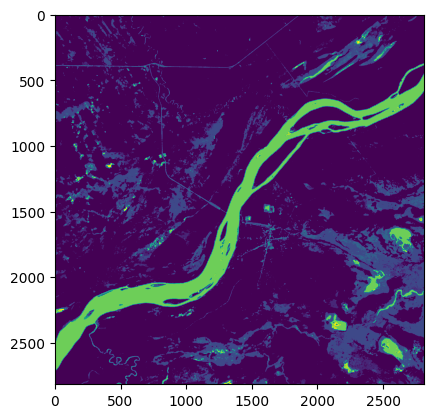

In [15]:
showmap(ground_classification_cropped_path)

### Calculate and present fuel and fire combustion analysis

In [16]:
#invest_image = workspace_dir + '/tot_c_cur.tif'
#gc_image = ground_classification_cropped_path
#bb_image = dt_analysis_path
# Compute the fuelmaps
carbon_out, bb_out, prio_out = compute_fuelmaps(workspace_dir + '/tot_c_cur.tif', ground_classification_cropped_path, dt_analysis_path, 0.5, 2000)
carbon_out_500, bb_out_500, prio_out_500 = compute_fuelmaps(workspace_dir + '/tot_c_cur.tif', ground_classification_cropped_path, dt_analysis_path, 0.5, 500)

# Show a table of the prioritized areas
#show_carbon_priority_table(carbon_out, bb_out, prio_out, 2000)

### Fuelmap

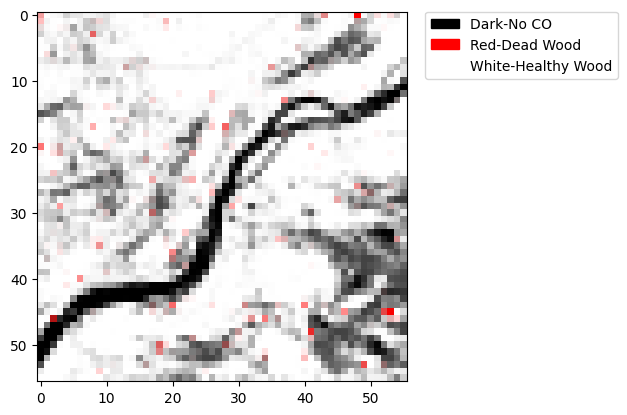

In [17]:
hsv_scaled = stack_hsv(bb_out_500, carbon_out_500)
hsv_imshow(hsv_scaled, hires_ticks=False)

### Fuel reduction priority segment map

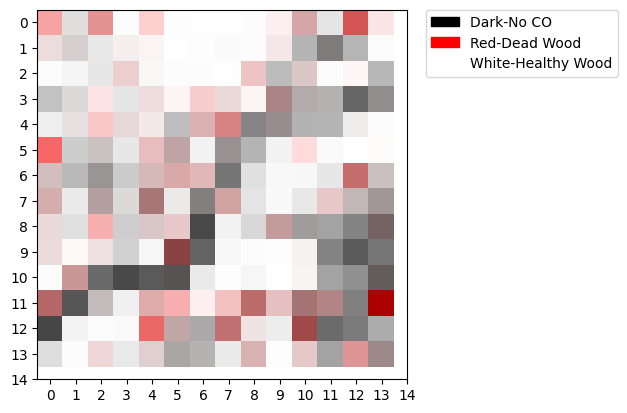

In [18]:
hsv_scaled = stack_hsv(bb_out, carbon_out)
hsv_imshow(hsv_scaled, hires_ticks=True)

### Fuel reduction segment priority list

In [19]:
show_carbon_priority_table(carbon_out, bb_out, prio_out, 2000)

      X   Y  Dead_tree(‰)  Carbon(Mg C)      Prio
167  13  11         1.800  23684.699219  6.529354
70    0   5         1.050  34188.160156  5.991458
172   4  12         1.000  32339.429688  5.686777
12   12   0         1.075  29144.730469  5.597373
96   12   6         0.800  27279.289062  4.671556
178  10  12         0.975  22157.419922  4.647955
63    7   4         0.700  29782.449219  4.565929
2     2   0         0.650  31643.449219  4.535222
0     0   0         0.600  33874.371094  4.508284
162   8  11         0.775  25963.230469  4.485700
175   7  12         0.750  26556.580078  4.462895
154   0  11         0.775  25049.958984  4.406100
194  12  13         0.600  30843.708984  4.301886
159   5  11         0.525  34170.820312  4.235526
114   2   8         0.525  34098.851562  4.231063
